**Trying out a linear model** 

In [90]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib 

import matplotlib.pyplot as plt 
from scipy.stats import skew 
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' 

In [91]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [92]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [93]:
all_data = pd.concat((train.loc[:, 'MSSubClass' : 'SaleCondition'], test.loc[:, 'MSSubClass': 'SaleCondition']))

**Data preprocessing**: 
- First I'll transform the skewed numeric features by taking log(feature+1) ~ this will make the features more normal 
- Create Dummy variables for the categorical features
- Replace the numeric missing values (NaN's) with the mean of their respective columns 

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price+1)'}>]], dtype=object)

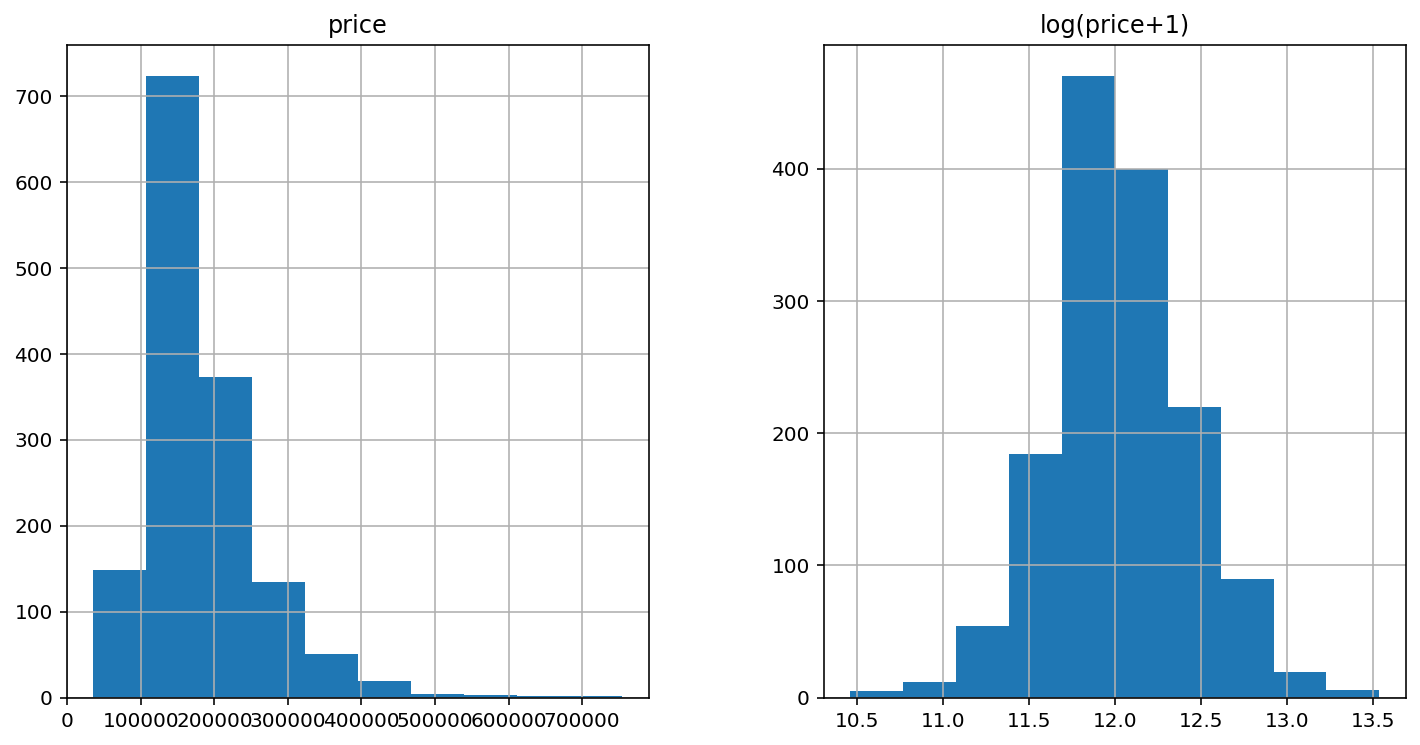

In [94]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({'price' :train['SalePrice'], 'log(price+1)' : np.log1p(train['SalePrice'])})
prices.hist()

In [95]:
#log transform the target:
train['SalePrice'] = np.log1p(train['SalePrice'])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute the skewness 
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index 

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [96]:
all_data = pd.get_dummies(all_data)

In [97]:
#filling Na's with the mean of the column: 
all_data = all_data.fillna(all_data.mean())

In [98]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y=train.SalePrice

**Models**

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(ridge) regularization. I'll also define a function thatreturns the cross-validation rmse error so we can evaluate our models and pick the best tuning par.

In [99]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring = 'neg_mean_squared_error', cv = 5))
    return(rmse)

In [100]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [101]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge

[0.13893637694024524,
 0.13777538277187862,
 0.13501433618086,
 0.13136184989399574,
 0.12864892446111872,
 0.12782179689257284,
 0.12733734668670774,
 0.1275294043975381,
 0.12895888148450027,
 0.13099437857191412,
 0.13316366423370268]

Text(0, 0.5, 'rmse')

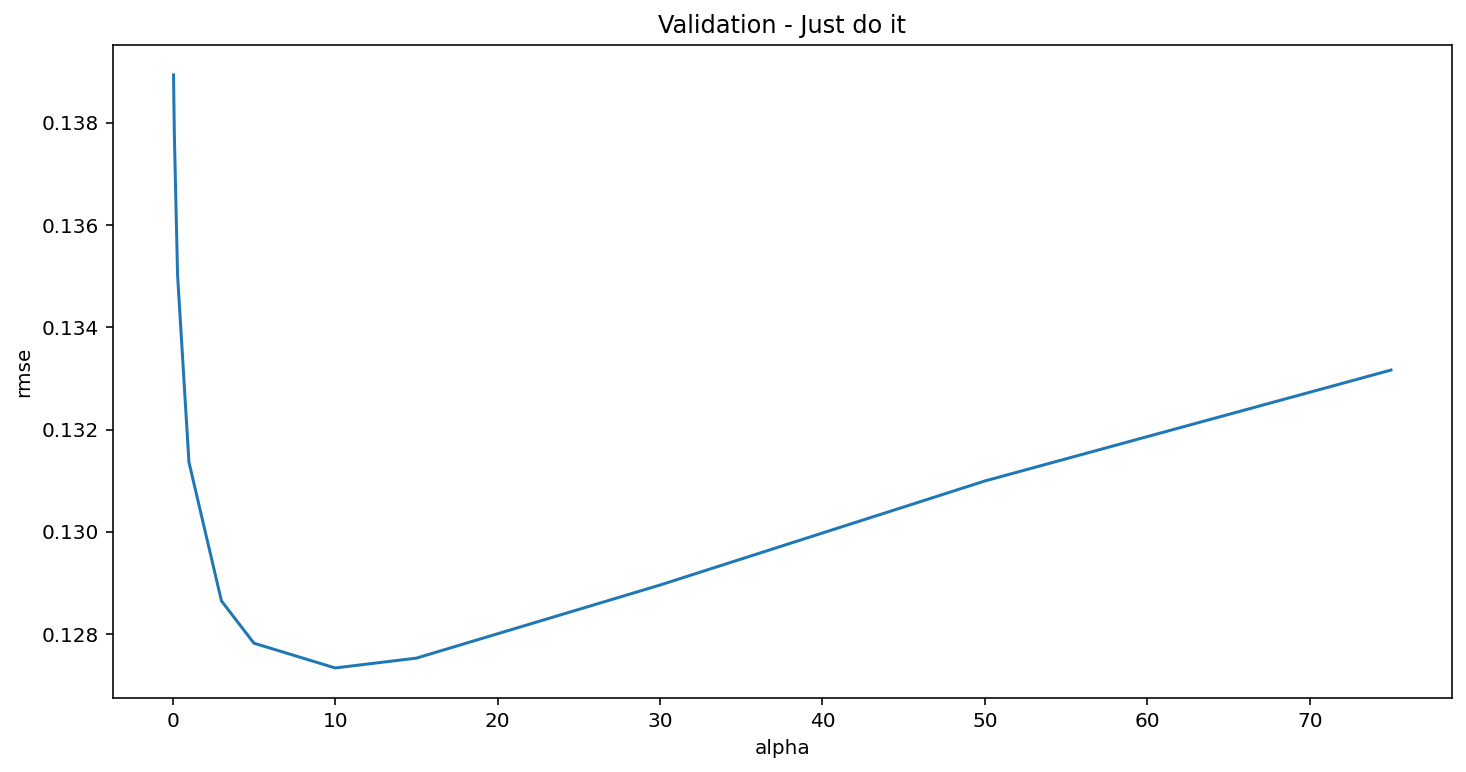

In [102]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = 'Validation - Just do it')
plt.xlabel('alpha')
plt.ylabel('rmse')

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above

In [103]:
cv_ridge.min()

0.12733734668670774

So for the Ridge regression we get a rmse of about 0.127

Let's try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [104]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.12256735885048127

Nice!The lasso performs even better so we'll just use this one to preidct on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting copefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [105]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
coef

MSSubClass              -0.007480
LotFrontage              0.000000
LotArea                  0.071826
OverallQual              0.053160
OverallCond              0.043027
                           ...   
SaleCondition_AdjLand    0.000000
SaleCondition_Alloca    -0.000000
SaleCondition_Family    -0.007925
SaleCondition_Normal     0.019666
SaleCondition_Partial    0.000000
Length: 288, dtype: float64

In [106]:
print('Lasso picked ' + str(sum(coef != 0)) + ' variables and eliminated the other ' + str(sum(coef==0)) + ' variables')

Lasso picked 110 variables and eliminated the other 178 variables


One thing to note here however is that the features selected are not necessary the 'correct' ones - especially sicne there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficietns are:

In [107]:
imp_coef = pd.concat([coef.sort_values().head(10),
                      coef.sort_values().tail(10)])

imp_coef.sort_values(inplace= True)

<AxesSubplot:>

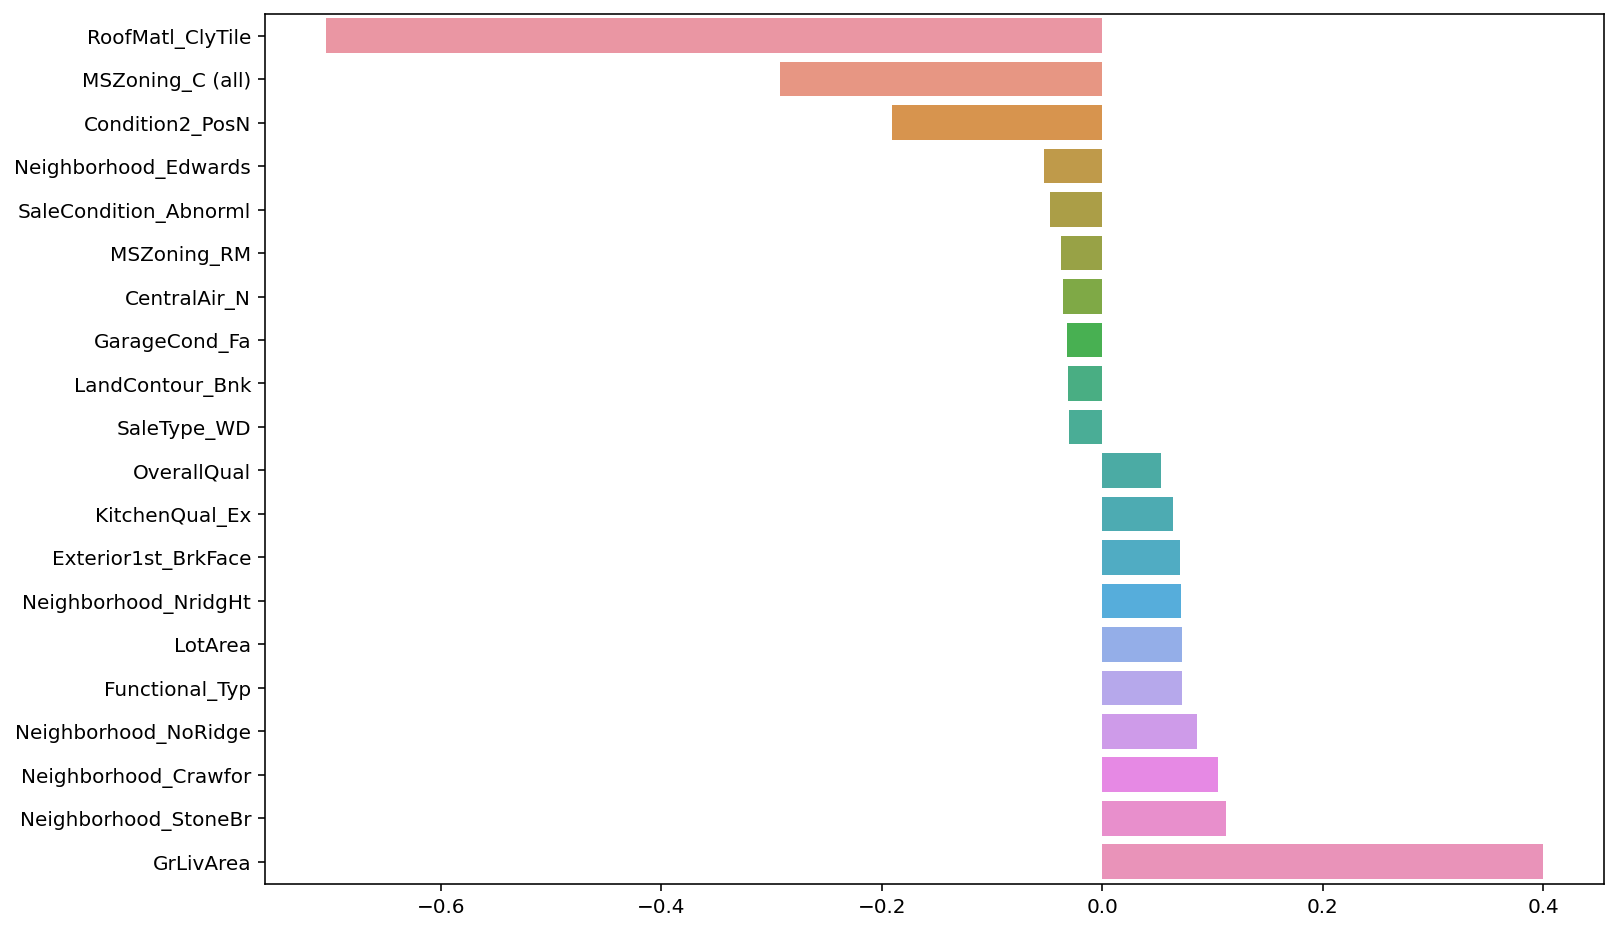

In [108]:
fig, ax = plt.subplots(figsize = (12,8))

sns.barplot(y = imp_coef.index, x = imp_coef.values)

The most important positive feature is ``GrLivArea`` - the above ground area by area square feet. This definitely sense. Then a few other and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables. 

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret

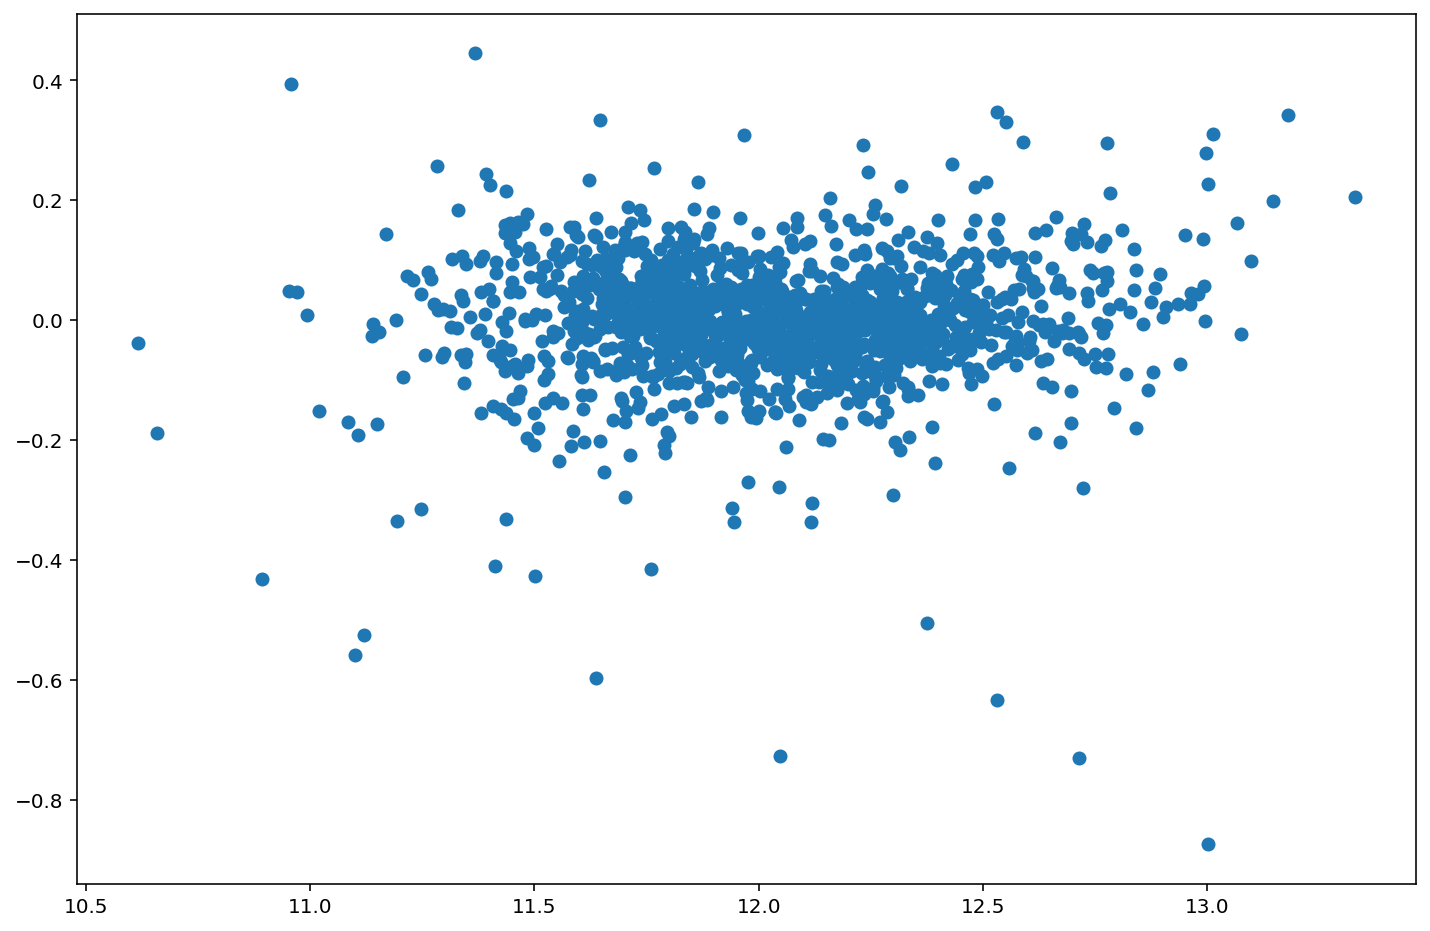

In [109]:
fig, ax = plt.subplots(figsize = (12,8))
preds = pd.DataFrame({'preds' : model_lasso.predict(X_train), 'true':y})
preds['res'] = preds['true'] - preds['preds']

ax.scatter( x = preds['preds'], y=preds['res'])

The residual plot looks pretty good. To wrap it up let's predict on the test set and submit on the leaderboard: 

**Adding an xgboost model:**

Let's add an xgboost model to our linear model to see if we can improve our score:

In [110]:
import xgboost as xgb 

In [111]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {'max_depth':2, 'eta' : 0.1}
model = xgb.cv(params, dtrain, num_boost_round = 500, early_stopping_rounds = 100)

<AxesSubplot:>

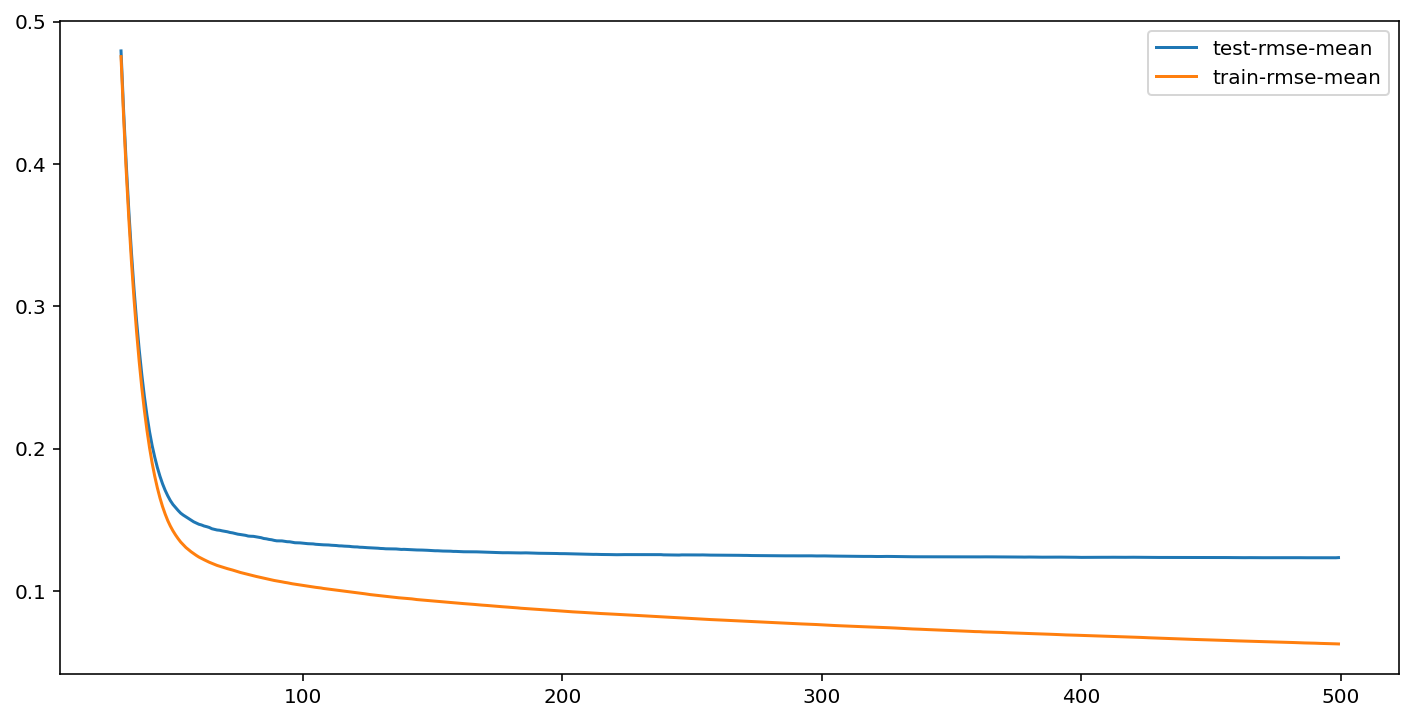

In [112]:
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()

In [113]:
model_xgb = xgb.XGBRegressor(n_estimators = 360, 
                             max_depth = 2,
                             learning_rate =0.1)  # the params were tuned using xgb.cv 
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [114]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

<AxesSubplot:xlabel='xgb', ylabel='lasso'>

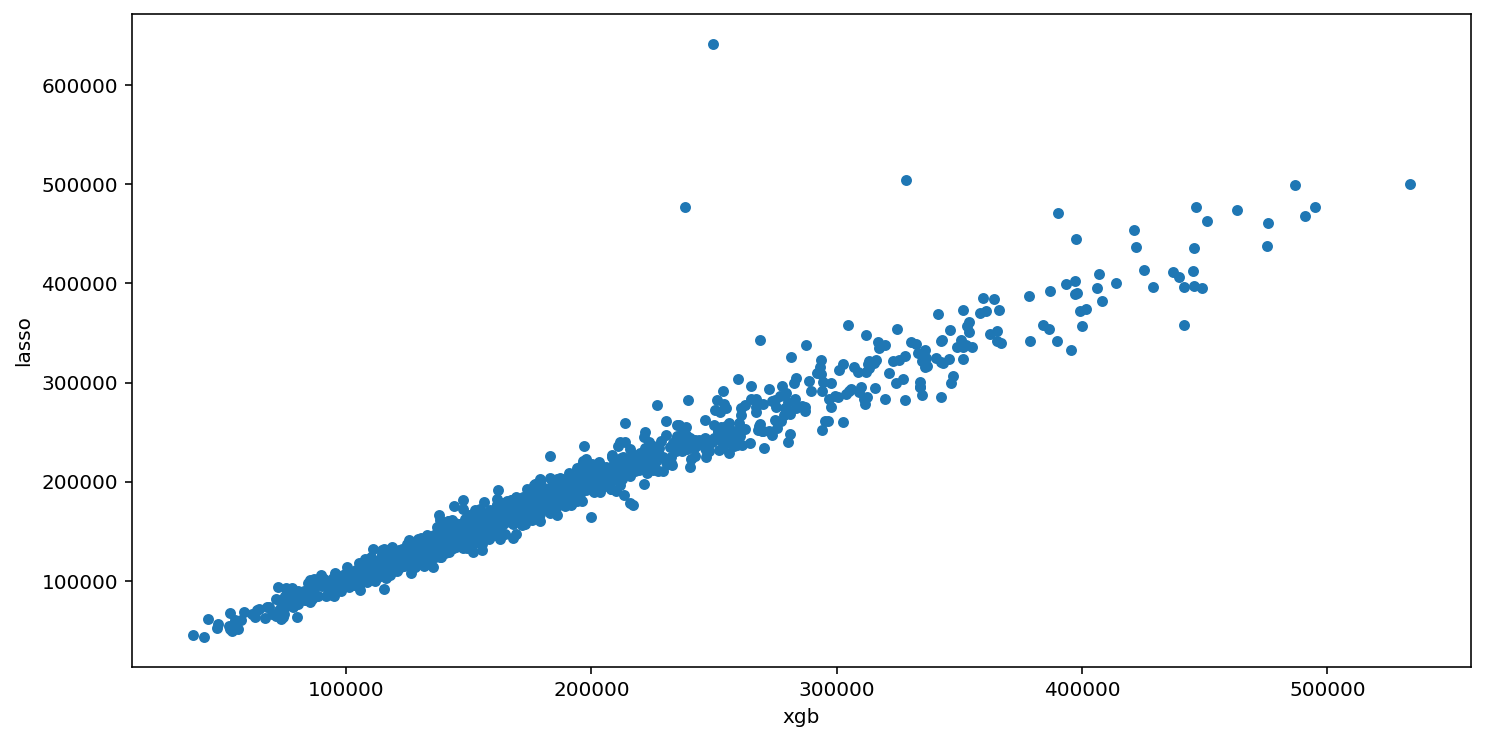

In [115]:
predictions = pd.DataFrame({'xgb' : xgb_preds, 'lasso' : lasso_preds})
predictions.plot(x='xgb', y = 'lasso', kind='scatter')

Many times it makes sense to take a weighted average of uncorrelated results- this usually improves the score although in this case it doesn't help that much. 

In [116]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [117]:
solutions = pd.DataFrame({'id':test.Id, 'SalePrice':preds})

**Trying out Keras**

Feedforward Neural Network doesn;t seem to work well at all... I wonder why.

In [125]:
from keras.layers import Dense
from keras.models import Sequential 
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

In [ ]:
X_train = StandardScaler().fit_transform(X_train)

In [ ]:
X_tr, X_val, y_tr, y_val = tran_test_split(X_train, y, random_state = 3)

In [ ]:
X_tr.shape

In [ ]:
X_tr

In [ ]:
model = Sequential()
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer = l1(0.001)))

model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
model.summary()

In [ ]:
hist = model.fit(X_tr, y_tr, validation_data =(X_val, y_val))

In [ ]:
pd.Series(model.predict(X_val)[:, 0]).hist()